In [97]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
import smogn
import pandas
from collections import Counter
from multiprocessing import Pool
from notebook import notebookapp
from numpy import matlib
from scipy import ndimage
import pickle
import util
import scipy.stats as stats

In [3]:
with open('/data/Ali/RadDBS-QSM/src/jupyter/pickles/segs_all', "rb") as fp:  
    segs = pickle.load(fp)

with open('/data/Ali/RadDBS-QSM/src/jupyter/pickles/qsms_all', "rb") as fp:  
    qsms = pickle.load(fp)

In [4]:
file_dir = '/data/Ali/RadDBS-QSM/src/csv'
# Load patient data
os.chdir(file_dir)
df = pd.read_csv('QSM anonymus- 6.22.2023-1528.csv')
# Make a copy
dfd = df.copy()
# Drop blank columns
for (columnName, columnData) in dfd.iteritems():
    if columnData.isnull().all():
        print('Dropping NaN column at',columnName)
        dfd.drop(columnName,axis=1,inplace=True)
# Add relevant column names from headers
for (columnName, columnData) in dfd.iteritems():
        dfd.rename(columns={columnName:columnName+': '+columnData.values[0]},inplace=True)

def drop_prefix(self, prefix):
    self.columns = self.columns.str.lstrip(prefix)
    return self

pd.core.frame.DataFrame.drop_prefix = drop_prefix

dfd.drop_prefix('Unnamed:')        
for (columnName, columnData) in dfd.iteritems():
    if columnName[1].isdigit():
        dfd.rename(columns={columnName:columnName[4:]},inplace=True)

# Make a copy for motor symptoms
motor_df = dfd.copy()
# Drop non-motor (III) columns
for (columnName, columnData) in motor_df.iteritems():
    if 'pre-dbs updrs' in columnName:
        next
    elif 'stim' in columnName:
        next
    elif 'CORNELL ID' in columnName:
        next
    else:
        motor_df.drop(columnName,axis=1,inplace=True)

# Drop subheader
motor_df = motor_df.tail(-1)
motor_df = motor_df.replace('na',np.nan)
motor_df

,CORNELL ID,OFF (pre-dbs updrs),ON (pre-dbs updrs),OFF meds ON stim 6mo,ON meds ON stim 6mo,off stim on med 6mo,off stim off med 6mo
1,67,60,41,31,29,NaN,NaN
2,only Ct data,43,12,NaN,20,18,NaN
3,74,34,11,NaN,17,NaN,NaN
4,84,53,13,NaN,34,NaN,NaN
5,75,62,8,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...
87,52,58,27,19,12,NaN,NaN
88,53,77,47,NaN,19,26,NaN
89,54,63,36,8,NaN,NaN,NaN
90,55,40,29,NaN,13,NaN,37


In [5]:
id = []
x_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/X')
for filename in x_directory:
    id.append(filename[14:][:-4])
df_post_dbs_off_meds_on_stim = motor_df['OFF meds ON stim 6mo'].to_numpy().astype('float')
df_post_dbs_off_meds_off_stim = motor_df[' off stim off med 6mo'].to_numpy().astype('float')
df_pre_dbs_off_meds = motor_df['OFF (pre-dbs updrs)'].to_numpy().astype('float')
df_pre_dbs_on_meds = motor_df['ON (pre-dbs updrs)'].to_numpy().astype('float')

cases = ~np.isnan(df_pre_dbs_off_meds+df_pre_dbs_on_meds+df_post_dbs_off_meds_on_stim)
pre_dbs_meds_improvement = (df_pre_dbs_off_meds[cases]-df_pre_dbs_on_meds[cases])/df_pre_dbs_off_meds[cases]
dbs_off_meds_improvement = (df_pre_dbs_off_meds[cases]-df_post_dbs_off_meds_on_stim[cases])/df_pre_dbs_off_meds[cases]
motor_df['CORNELL ID'].replace('only Ct data ', np.nan, inplace=True)
pids = motor_df['CORNELL ID'].to_numpy().astype('float')
subs = pids[cases]
subs_in = (np.intersect1d(subs,np.asarray(id).astype(float)))
df_pre_dbs_off_meds_in = df_pre_dbs_off_meds[cases]
pre_dbs_off_meds_in = df_pre_dbs_off_meds_in[np.in1d(subs,np.asarray(id).astype(float))]

In [6]:
Phi_all = []
n_rois = 6
n_features = 1596
n_cases = 35
X_all = np.zeros((n_cases,n_rois,n_features))
R_all = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
K_all = np.zeros((n_cases,n_rois,n_features-1)).astype(str)
phi_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw_new')
X_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/X')
R_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/R')
K_directory = os.listdir('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/K')
# Load all feature structures
for feature_matrix in phi_directory:
    with open('/data/Ali/RadDBS-QSM/src/jupyter/phi/parallel/msw_new/'+feature_matrix, "rb") as fp:  
        Phi_case = pickle.load(fp)
        Phi_all.append(Phi_case)

# Load feature arrays
count = 0
for feature_array in X_directory:
    X_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/X/'+feature_array)
    X_all[count,:,:] = X_case.reshape((n_rois,n_features)).transpose((0,1))
    count = count+1

# Load ROI indices
count = 0
for feature_roi in R_directory:
    R_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/R/'+feature_roi)
    R_all[count,:,:] = R_case.reshape((n_rois,n_features-1)).transpose((0,1))
    count = count+1

# Load key indices
count = 0
for feature_key in K_directory:
    K_case = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/parallel/msw_new/K/'+feature_key)
    K_all[count,:,:] = K_case.reshape((n_rois,n_features-1)).transpose((0,1))
    count = count+1


In [8]:
n_cases_train = n_cases-10

ut_ls = np.zeros((n_cases_train))
ut_qr = np.zeros((n_cases_train))

# Normalize training cases together
#   Set with_mean=False to preserve data sparsity
#   And with_std=False 
#   However, need a significant number of samples to do this
X_all_r = X_all[:n_cases_train,:,:].reshape(n_cases_train,((n_features)*n_rois))
scaler = StandardScaler()
# Transform feature matrix and UPDRS
X_all_t = scaler.fit_transform(X_all_r)

dbs_off_meds_improvement_in = dbs_off_meds_improvement[np.in1d(subs,np.asarray(id).astype(float))]
pre_dbs_meds_improvement_in = pre_dbs_meds_improvement[np.in1d(subs,np.asarray(id).astype(float))]


# Create data frame for SMOGN generation
dbs_off_meds_improvement_in_train = dbs_off_meds_improvement_in[:n_cases_train]
pre_dbs_meds_improvement_in_train = pre_dbs_meds_improvement[:n_cases_train]
D = pd.DataFrame(np.hstack((X_all_t,(dbs_off_meds_improvement_in_train.reshape(n_cases_train,1)))))
for col in D.columns:
    D.rename(columns={col:str(col)},inplace=True)

# Specify phi relevance values
Rm = [[np.min(dbs_off_meds_improvement_in_train),  1, 0],  ## over-sample ("minority")
    [np.mean(dbs_off_meds_improvement_in_train), 0, 0]]#,  ## under-sample ("majority")
    #[np.max(dbs_off_meds_improvement_in_train),  1, 0]]

resmogn = 0
if resmogn == 1:
    # Conduct SMOGN
    print('Prior to SMOGN sampling, mean is',X_all_t.mean(),'standard deviation is',X_all_t.std())
    X_smogn1 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance',pert=0.5)
    X_smogn2 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance',pert=0.1)
    X_smogn3 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance',pert=0.05)
    X_smogn4 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance',pert=0.025)
    X_smogn5 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance')

    X_smogn = np.vstack((X_smogn1,X_smogn2,X_smogn3,X_smogn4,X_smogn5))
else:
    X_smogn = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/X_smogn_test.npy')
    X_smogn_best = X_smogn
# Drop label
X_in_s = np.array(X_smogn)[:,:-1] 
print('After SMOGN sampling, mean is',X_in_s.mean(),'standard deviation is',X_in_s.std())
X_in_s = scaler.fit_transform(((X_in_s)))#,X_all_t)))
print('Standardizing the SMOGN dataset gives, mean',X_in_s.mean(),'standard deviation',X_in_s.std())

for j in np.arange(X_in_s.shape[1]):
    if np.array_equal(X_in_s[:,j],np.array(X_smogn)[:,-1]) == 0:
        next
    else:
        print('Labels detected at column',j)

smogn_per_change_in = np.asarray(X_smogn)[:,-1]

After SMOGN sampling, mean is 0.035780477166415775 standard deviation is 0.87114613719097
Standardizing the SMOGN dataset gives, mean -2.921639538487254e-20 standard deviation 0.9542040820716878


In [30]:
X_smogn1 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance',pert=0.5)
X_smogn2 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance',pert=0.1)
X_smogn3 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance',pert=0.05)
X_smogn4 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance',pert=0.025)
X_smogn5 = smogn.smoter(data = D, y = str(D.columns[-1]),rel_method = 'manual',rel_ctrl_pts_rg = Rm,samp_method='balance')

r_index: 100%|##########| 3/3 [00:07<00:00,  2.55s/it]
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.
r_index: 100%|##########| 3/3 [00:06<00:00,  2.04s/it]
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
r_index: 100%|##########| 3/3 [00:07<00:00,  2.51s/it]
/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site

In [33]:
X_smogn = np.load('/data/Ali/RadDBS-QSM/src/jupyter/npy/X_smogn_test.npy')
X_smogn_best = X_smogn

In [36]:
X_smogn = np.vstack((X_smogn_best,X_smogn1,X_smogn2,X_smogn3,X_smogn4,X_smogn5))
# Drop label
X_in_s = np.array(X_smogn)[:,:-1] 
print('After SMOGN sampling, mean is',X_in_s.mean(),'standard deviation is',X_in_s.std())
X_in_s = scaler.fit_transform(((X_in_s)))#,X_all_t)))
print('Standardizing the SMOGN dataset gives, mean',X_in_s.mean(),'standard deviation',X_in_s.std())

for j in np.arange(X_in_s.shape[1]):
    if np.array_equal(X_in_s[:,j],np.array(X_smogn)[:,-1]) == 0:
        next
    else:
        print('Labels detected at column',j)

smogn_per_change_in = np.asarray(X_smogn)[:,-1]

After SMOGN sampling, mean is 0.028728124626450517 standard deviation is 0.8414756610127697
Standardizing the SMOGN dataset gives, mean -2.529768838483805e-19 standard deviation 0.9542040820716878


In [45]:
per_change_in = dbs_off_meds_improvement_in[:n_cases_train]
per_change_test = dbs_off_meds_improvement_in[n_cases_train:]

for j in np.arange(X_in_s.shape[1]):
    if np.array_equal(X_in_s[:,j],np.array(X_smogn)[:,-1]) == 0:
        next
    else:
        print('Labels detected at column',j)

smogn_per_change_in = np.asarray(X_smogn)[:,-1]
Cs = np.zeros_like(X_in_s)
C = np.zeros_like(X_all_t)
cv = KFold(n_splits=X_in_s.shape[0],shuffle=True)
cvc = KFold(n_splits=X_all_t.shape[0],shuffle=True)
clf_s = LassoCV(max_iter=10000,cv=cv,eps=0.5,n_jobs=-1,verbose=True).fit(X_in_s,smogn_per_change_in)
clf_c = LassoCV(max_iter=10000,cv=cvc,eps=0.5,n_jobs=-1,verbose=True).fit(X_all_t,per_change_in)


X_all_q = scaler.fit_transform(X_all[n_cases_train:,:,:].reshape(n_cases-n_cases_train,((n_features)*n_rois)))
ut_ls = clf_s.predict(X_all_q)
ut_lsc = clf_c.predict(X_all_q)
dbs_target = dbs_off_meds_improvement_in[n_cases_train:]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

<function matplotlib.pyplot.show(close=None, block=None)>

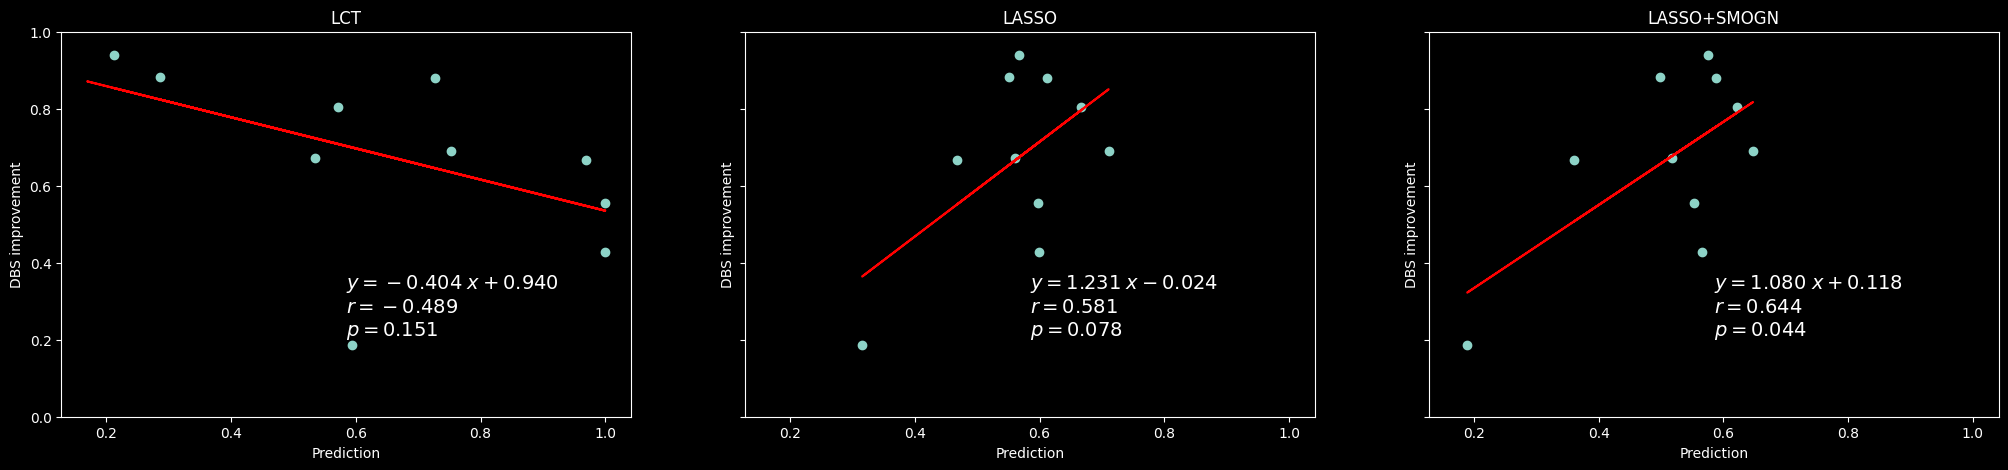

In [46]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,5)
# Cross validation results
[fig,ax] = plt.subplots(1,3,sharex=True, sharey=True)
lr_prepost = linregress(pre_dbs_meds_improvement_in[n_cases_train:],dbs_off_meds_improvement_in[n_cases_train:])
ax[0].scatter(pre_dbs_meds_improvement_in[n_cases_train:],dbs_off_meds_improvement_in[n_cases_train:])
ax[0].plot(pre_dbs_meds_improvement_in,pre_dbs_meds_improvement_in*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
ax[0].set_ylim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.5, 0.375, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')

lr_pred_ls = linregress(ut_lsc,dbs_target)
ax[1].scatter(ut_lsc,dbs_target)
ax[1].plot(ut_lsc,ut_lsc*lr_pred_ls.slope+lr_pred_ls.intercept,'-r')
ax[1].set_title('LASSO')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_ls.slope:0.3f}\;x{lr_pred_ls.intercept:+0.3f}$\n$r = {lr_pred_ls.rvalue:0.3f}$\n$p = {lr_pred_ls.pvalue:0.3f}$"
ax[1].text(0.5, 0.375, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')

lr_pred_ls = linregress(ut_ls,dbs_target)
ax[2].scatter(ut_ls,dbs_target)
ax[2].plot(ut_ls,ut_ls*lr_pred_ls.slope+lr_pred_ls.intercept,'-r')
ax[2].set_title('LASSO+SMOGN')
ax[2].set_ylabel("DBS improvement")
ax[2].set_xlabel("Prediction")
text = f"$y={lr_pred_ls.slope:0.3f}\;x{lr_pred_ls.intercept:+0.3f}$\n$r = {lr_pred_ls.rvalue:0.3f}$\n$p = {lr_pred_ls.pvalue:0.3f}$"
ax[2].text(0.5, 0.375, text,transform=ax[2].transAxes,
     fontsize=14, verticalalignment='top')

plt.style.use('dark_background')
plt.show

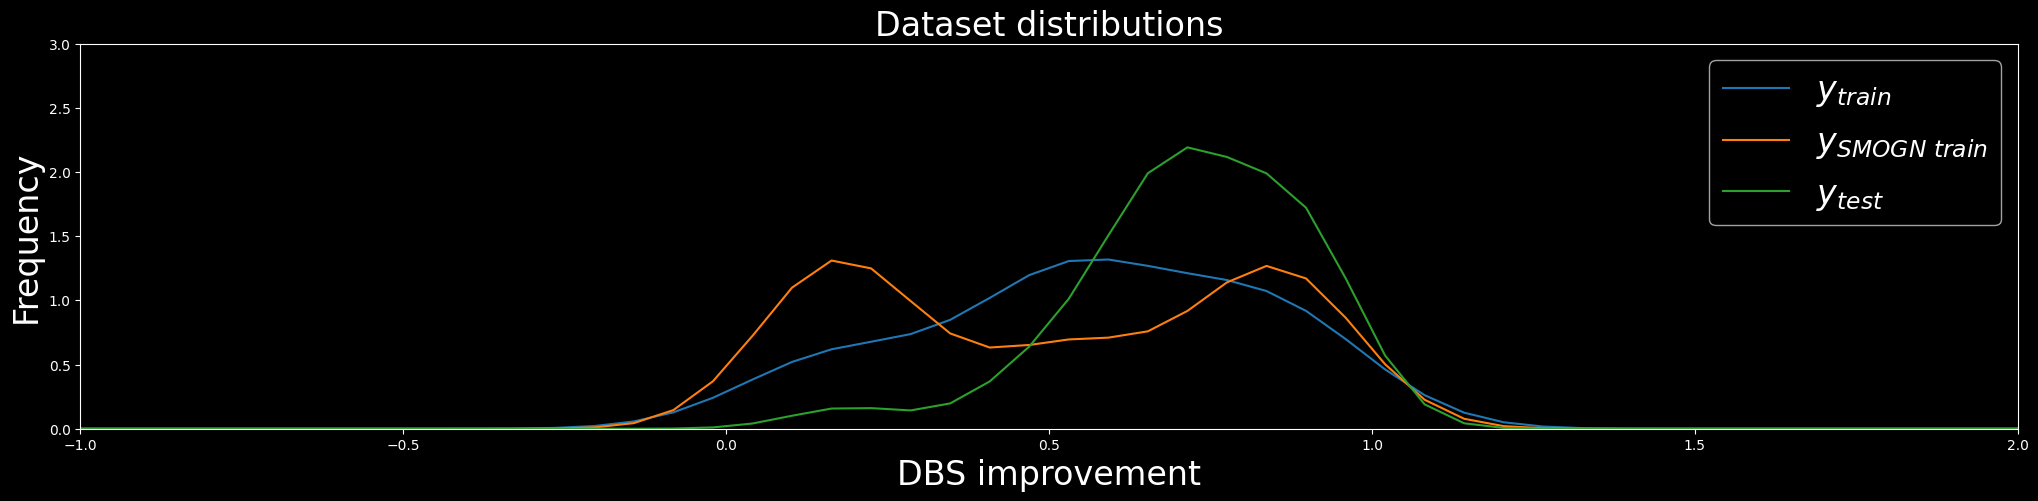

In [67]:
density_train = stats.gaussian_kde(dbs_off_meds_improvement_in_train)
density_test = stats.gaussian_kde(dbs_off_meds_improvement[n_cases_train:])
n, x, _ = plt.hist(dbs_off_meds_improvement_in_train, bins=np.linspace(-1, 2, 50), 
                   histtype=u'step', density=True,color='tab:blue',linewidth=0)  
plt.plot(x, density_train(x),color='tab:blue',label=r'$y_{train}$')
density_smogn = stats.gaussian_kde(np.array(X_smogn)[:,-1])
n, y, _ = plt.hist(np.array(X_smogn)[:,-1], bins=np.linspace(-1, 2, 50), 
                   histtype=u'step', density=True,color='tab:orange',linewidth=0)  
plt.plot(y, density_smogn(y),color='tab:orange',label=r'$y_{SMOGN \ train}$')
plt.plot(y, density_test(y),color='tab:green',label=r'$y_{test}$')
plt.legend(fontsize=24)
plt.xlim([-1,2])
plt.ylim([0,3])
plt.xlabel('DBS improvement',fontsize=24)
plt.ylabel('Frequency',fontsize=24)
plt.title('Dataset distributions',fontsize=24)
plt.show()

In [98]:
N_samples = 20
for j in np.arange(N_samples):
    X_train,X_test,per_change_train,per_change_test,train_index,test_index = util.set_split(X_all_t,dbs_off_meds_improvement,1,0.2)

AttributeError: module 'util' has no attribute 'set_split'

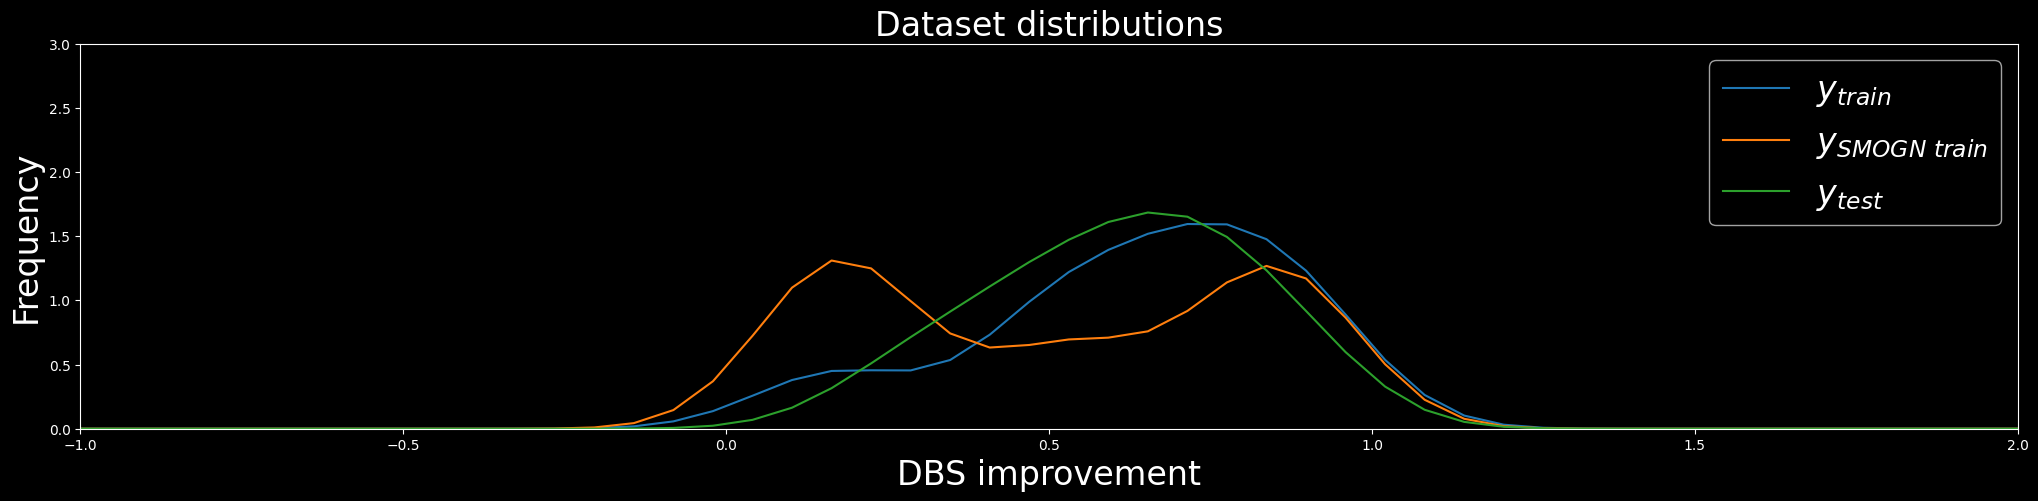

In [96]:
density_train = stats.gaussian_kde(per_change_train)
density_test = stats.gaussian_kde(per_change_test)
n, x, _ = plt.hist(dbs_off_meds_improvement_in_train, bins=np.linspace(-1, 2, 50), 
                   histtype=u'step', density=True,color='tab:blue',linewidth=0)  
plt.plot(x, density_train(x),color='tab:blue',label=r'$y_{train}$')
density_smogn = stats.gaussian_kde(np.array(X_smogn)[:,-1])
n, y, _ = plt.hist(np.array(X_smogn)[:,-1], bins=np.linspace(-1, 2, 50), 
                   histtype=u'step', density=True,color='tab:orange',linewidth=0)  
plt.plot(y, density_smogn(y),color='tab:orange',label=r'$y_{SMOGN \ train}$')
plt.plot(y, density_test(y),color='tab:green',label=r'$y_{test}$')
plt.legend(fontsize=24)
plt.xlim([-1,2])
plt.ylim([0,3])
plt.xlabel('DBS improvement',fontsize=24)
plt.ylabel('Frequency',fontsize=24)
plt.title('Dataset distributions',fontsize=24)
plt.show()